In [6]:
import re
import string
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder

In [7]:
import numpy as np

In [8]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
customer_feedback = pd.read_csv("Data/sentiment-analysis.csv")

customer_feedback[['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']] = customer_feedback['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'].str.split(',', expand = True)

customer_feedback = customer_feedback.drop('Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score', axis=1)
customer_feedback.head()

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88


In [9]:
def clean_text(text: pd.Series) -> pd.Series:
    """
    Function cleans the text column by:
    - Converting text to lowercase
    - Removing special characters, digits
    - Removing extra spaces
    
    Parameters
    ----------
    text : pd.Series
        Text column (pandas Series of strings, e.g., reviews).
    
    Returns
    -------
    text : pd.Series
        Column with cleaned text.
    """
    # Ensure text is in lowercase
    text = text.str.lower()
    
    # Remove any special characters and digits
    text = text.str.replace(r'[^a-z\s]', '', regex=True)
    
    # Remove extra spaces between words
    text = text.str.replace(r'\s+', ' ', regex=True).str.strip()

    return text

In [11]:
customer_feedback['Cleaned_Text'] = clean_text(customer_feedback['Text'])
customer_feedback['Sentiment'] = customer_feedback['Sentiment'].str.strip()

customer_feedback = customer_feedback.dropna()
customer_feedback

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score,Cleaned_Text
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85,i love this product
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65,the service was terrible
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92,this movie is amazing
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78,im so disappointed with their customer support
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88,just had the best meal of my life
...,...,...,...,...,...,...,...,...
91,"""Just had the most amazing vacation! I can't w...",Positive,TripAdvisor,2023-07-02 18:01:23,travelenthusiast1,Sydney,0.93,just had the most amazing vacation i cant wait...
92,"""The food at this restaurant was awful. Never ...",Negative,Zomato,2023-07-02 20:45:37,foodlover123,Mumbai,0.55,the food at this restaurant was awful never go...
93,"""I can't stop listening to this song. It's my ...",Positive,Spotify,2023-07-03 09:17:52,musiclover789,Berlin,0.91,i cant stop listening to this song its my new ...
94,"""Their website is so confusing and poorly desi...",Negative,Website Review,2023-07-03 11:59:18,user789,Toronto,0.68,their website is so confusing and poorly designed


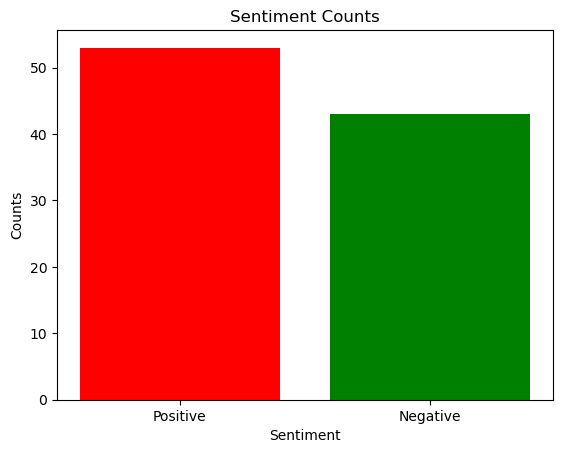

In [13]:
sentiment_counts = customer_feedback['Sentiment'].value_counts()

# Plotting the sentiment counts as a bar chart
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green'])

# Adding titles and labels
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

# Displaying the plot
plt.show()


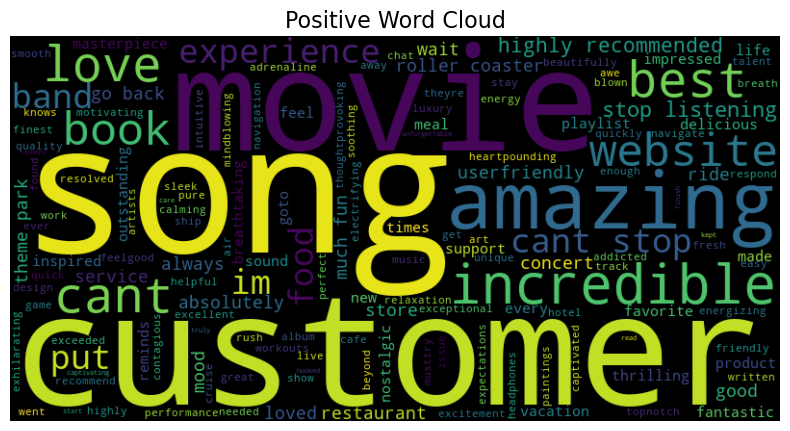

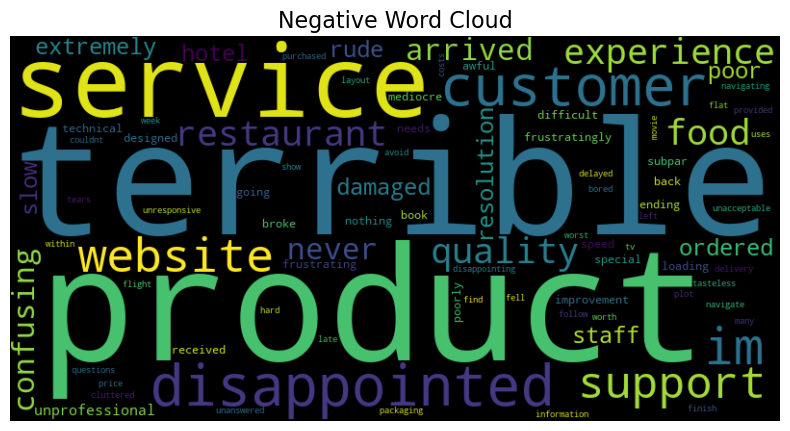

In [15]:
# Separate positive and negative reviews
positive_text = ' '.join(customer_feedback[customer_feedback['Sentiment'] == 'Positive']['Cleaned_Text'])
negative_text = ' '.join(customer_feedback[customer_feedback['Sentiment'] == 'Negative']['Cleaned_Text'])

# Stopwords
stop_words = set(stopwords.words('english'))

# Generate word clouds
def plot_wordcloud(text, title, stopwords):
    if not text.strip():  
        print(f"No words to generate a word cloud for: {title}")
        return
    
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='black',
        stopwords=stopwords,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Plot word clouds for positive and negative reviews
plot_wordcloud(positive_text, "Positive Word Cloud", stop_words)
plot_wordcloud(negative_text, "Negative Word Cloud", stop_words)



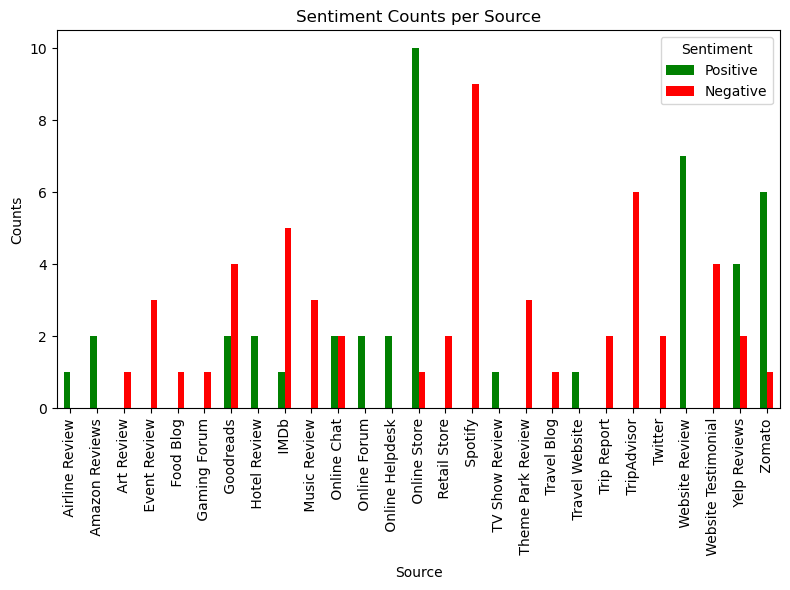

In [17]:
# Analysing Number of Positive and Negative Feedback Per Source
# Grouping data by 'Source' and 'Sentiment' and counting occurrences
sentiment_counts = customer_feedback.groupby(['Source', 'Sentiment']).size().unstack(fill_value=0)

# Plotting the sentiment counts as a bar chart
sentiment_counts.plot(kind='bar', stacked=False, color=['green', 'red'], figsize=(8, 6))

# Adding titles and labels
plt.title('Sentiment Counts per Source')
plt.xlabel('Source')
plt.ylabel('Counts')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])

# Displaying the plot
plt.tight_layout()
plt.show()


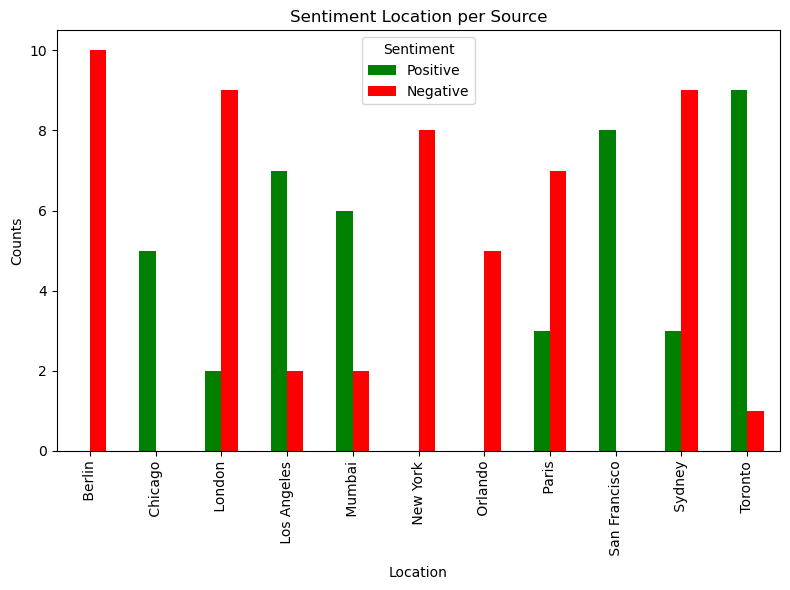

In [19]:
# Analysing Number of Positive and Negative Feedback Per Location
# Grouping data by 'Location' and 'Sentiment' and counting occurrences
sentiment_counts = customer_feedback.groupby(['Location', 'Sentiment']).size().unstack(fill_value=0)

# Plotting the sentiment counts as a bar chart
sentiment_counts.plot(kind='bar', stacked=False, color=['green', 'red'], figsize=(8, 6))

# Adding titles and labels
plt.title('Sentiment Location per Source')
plt.xlabel('Location')
plt.ylabel('Counts')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])

# Displaying the plot
plt.tight_layout()
plt.show()

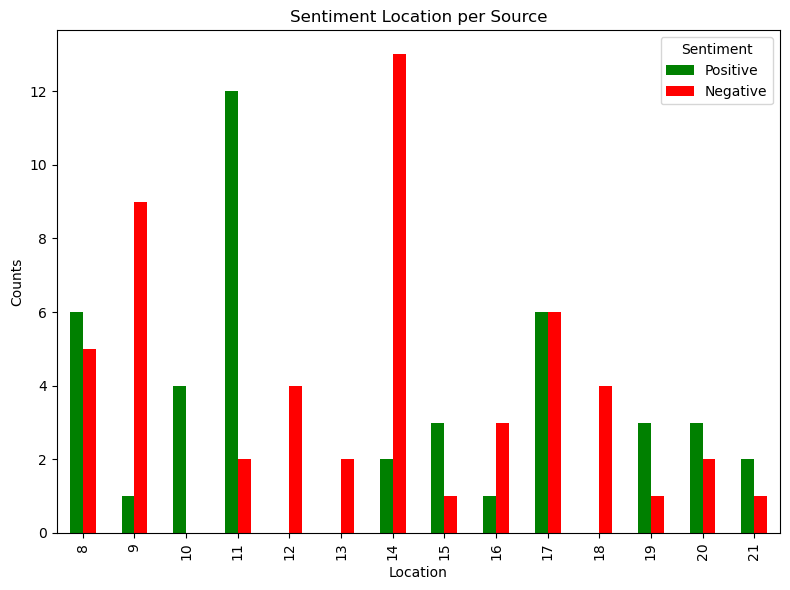

In [21]:
# Ensure the column is in datetime format
customer_feedback['Time'] = pd.to_datetime(customer_feedback['Date/Time'])

# Extract the start of the hour (only the hour component)
customer_feedback['Hour'] = customer_feedback['Time'].dt.hour

# Analysing Number of Positive and Negative Feedback Per Hour
# Grouping data by 'Hour' and 'Sentiment' and counting occurrences
sentiment_counts = customer_feedback.groupby(['Hour', 'Sentiment']).size().unstack(fill_value=0)

# Plotting the sentiment counts as a bar chart
sentiment_counts.plot(kind='bar', stacked=False, color=['green', 'red'], figsize=(8, 6))

# Adding titles and labels
plt.title('Sentiment Location per Source')
plt.xlabel('Location')
plt.ylabel('Counts')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])

# Displaying the plot
plt.tight_layout()
plt.show()

In [23]:
import pandas as pd
import random

# Define a dictionary of synonyms for positive and negative words
synonym_dict = {
    'Positive': ['it is good', 'great', 'fantastic', 'awesome', 'love', 'amazing', 'wonderful', 'excellent'],
    'Negative': ['bad', 'horrible', 'terrible', 'awful', 'hate', 'disappointing', 'poor', 'lousy']
}

customer_feedback = customer_feedback[['Sentiment', 'Cleaned_Text']]

# Create a list to store the data
df = []

# Add positive examples to the data list
for text in synonym_dict['Positive']:
    df.append([text, 'Positive'])

# Add negative examples to the data list
for text in synonym_dict['Negative']:
    df.append([text, 'Negative'])

# Create a DataFrame from the data list
df = pd.DataFrame(df, columns=['Cleaned_Text', 'Sentiment'])

# Append the newly created DataFrame to the original customer_feedback DataFrame
customer_feedback = pd.concat([customer_feedback, df], ignore_index=True)


In [25]:
# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    customer_feedback['Cleaned_Text'], customer_feedback['Sentiment'], test_size=0.2, random_state=42
)

# Map the labels to numerical values (0 for Negative, 1 for Positive)
train_labels = train_labels.map({'Negative': 0, 'Positive': 1})
test_labels = test_labels.map({'Negative': 0, 'Positive': 1})

# Tokenize the training data
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_inputs = tokenizer(
    list(train_texts),  # Ensure train_texts is a list
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

# Tokenize testing data
test_inputs = tokenizer(
    list(test_texts),  # Ensure test_texts is a list
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

# Define the number of labels for classification
num_labels = 2

# Load the model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Convert tokenized inputs and labels into a TensorDataset for training
train_dataset = TensorDataset(
    train_inputs['input_ids'],
    train_inputs['attention_mask'],
    torch.tensor(train_labels.values, dtype=torch.long)  # Ensure labels are torch tensors of integers
)

# Create DataLoader for training
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create DataLoader for testing
test_dataset = TensorDataset(
    test_inputs['input_ids'],
    test_inputs['attention_mask'],
    torch.tensor(test_labels.values, dtype=torch.long)  # Ensure test labels are torch tensors
)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


C:\Users\manas\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Pleas

In [29]:
from transformers import AdamW  # Import AdamW optimizer


In [31]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=0.01)

# Initialize variables for early stopping and training loss tracking
best_train_loss = float('inf')
counter = 0
patience = 3  # Number of epochs without improvement before early stopping
epochs = 6

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    for batch in train_dataloader:  # Iterate through the DataLoader
        input_ids, attention_mask, labels = batch  # Unpack the batch into individual components

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Print the average training loss for this epoch
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}")

    # Early stopping based on training loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping due to no improvement in training loss.")
            break

C:\Users\manas\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6, Training Loss: 0.7069845994313558
Epoch 2/6, Training Loss: 0.682934989531835
Epoch 3/6, Training Loss: 0.6648760239283243
Epoch 4/6, Training Loss: 0.6219738920529684
Epoch 5/6, Training Loss: 0.5662379264831543
Epoch 6/6, Training Loss: 0.5317060053348541


In [8]:
import torch

# Define save path
save_path = "./sentiment_model"

# Save model & tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Model saved successfully!")


NameError: name 'model' is not defined

In [10]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the saved model
model = BertForSequenceClassification.from_pretrained(save_path)
tokenizer = BertTokenizer.from_pretrained(save_path)

print("Model loaded successfully!")


Model loaded successfully!


In [12]:
sample_review = "This website forced me to add extra items to the cart!"
inputs = tokenizer(sample_review, return_tensors="pt", padding=True, truncation=True)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

predicted_class = torch.argmax(outputs.logits, dim=1).item()
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

print(f"Predicted Sentiment: {sentiment_labels[predicted_class]}")


Predicted Sentiment: Negative


In [14]:
sample_review = "This website is trustworthy!"
inputs = tokenizer(sample_review, return_tensors="pt", padding=True, truncation=True)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

predicted_class = torch.argmax(outputs.logits, dim=1).item()
sentiment_labels = {0: "Negative", 1: "Positive"}

print(f"Predicted Sentiment: {sentiment_labels[predicted_class]}")


Predicted Sentiment: Positive


In [22]:
pip install selenium


   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB 262.6 kB/s eta 0:00:36
   ---------------------------------------- 0.0/9.4 MB 262.6 kB/s eta 0:00:36
   ---------------------------------------- 0.0/9.4 MB 178.6 kB/s eta 0:00:53
   ---------------------------------------- 0.0/9.4 MB 178.6 kB/s eta 0:00:53
   ---------------------------------------- 0.1/9.4 MB 204.8 kB/s eta 0:00:46
   ---------------------------------------- 0.1/9.4 MB 196.9 kB/s eta 0:00:48
   ---------------------------------------- 0.1/9.4 MB 273.1 kB/s eta 0:00:34
    --------------------------------------- 0.1/9.4 MB 277.4 kB/s eta 0:00:34
    --------------------------------------- 0.2/9.4 MB 305.7 kB/s eta 0:00:31
    -----------------

In [26]:
pip install webdriver_manager

Note: you may need to restart the kernel to use updated packages.


In [18]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

In [20]:
# Set up Selenium WebDriver
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Run without opening browser
options.add_argument("--disable-blink-features=AutomationControlled")  # Bypass bot detection

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Open Amazon product review page
# amazon_url = "https://www.amazon.in/Daikin-Inverter-Display-Technology-MTKL50U/dp/B0BK1KS6ZD/"
amazon_url="https://www.amazon.in/Daikin-Fixed-Copper-Filter-FTL28U/dp/B09R4SF5SP/"
driver.get(amazon_url)

# Wait for elements to load
time.sleep(5)

# Find review elements
review_elements = driver.find_elements(By.CLASS_NAME, "a-size-base.review-text")

reviews = [review.text.strip() for review in review_elements if review.text.strip()]

# Print extracted reviews
print("\nExtracted Amazon Reviews:")
for i, review in enumerate(reviews[:5], 1):  # Get first 5 reviews
    print(f"Review {i}: {review}\n\n\n\n")

driver.quit()


Extracted Amazon Reviews:
Review 1: I am trying to summarise this in few points:-

1. This one is my 3rd AC in my apartment, and first from Daikin, that to from online platform (previous ones were from Hitachi). I shall suggest go for an window AC for its sheer longevity and ease of use and service. But if not possible then go for split unit and Daikin is a fair choice.
2. This one is for my one of my kid's room of 105 sqft. The IDU and HDU is very sturdy for its price reference and relatively large in size and can be compared to an 1 ton AC.
3. It's a non inverter AC thus, compressor doesn't work all the time and less fault prone without the PCB and electronics, still very energy efficient. It consumed ~4 units for 11 pm to 6 am operation yesterday. It cools the room within 10 minutes.
4. Their Installation charges are quite steep but Daikin sent me a rate chart in advance. Technician Adil was efficient and humble and done a good job. Unlike other brands In Daikin the power goes to H

In [22]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load sentiment analysis model
save_path = "./sentiment_model"
model = BertForSequenceClassification.from_pretrained(save_path)
tokenizer = BertTokenizer.from_pretrained(save_path)
print("Model Loaded.")
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

def analyze_sentiment(text):
    print("Analyzing reviews.........")
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    return sentiment_labels[predicted_class]

# Analyze first 5 reviews
for i, review in enumerate(reviews[:5], 1):
    sentiment = analyze_sentiment(review)
    print(f"Review {i}: {sentiment}")

Model Loaded.
Analyzing reviews.........
Review 1: Negative
Analyzing reviews.........
Review 2: Neutral
Analyzing reviews.........
Review 3: Negative
Analyzing reviews.........
Review 4: Negative
